# Xây dựng mô hình dự đoán khách hàng rời mạng viến thông

Giữ chân khách hàng là yếu tố then chốt cho sự thành công của một công ty, đặc biệt trong một ngành cạnh tranh như dịch vụ viễn thông. Thu hút khách hàng mới không chỉ khó khăn hơn mà còn tốn kém hơn nhiều so với việc duy trì mối quan hệ với khách hàng hiện tại. Trong dự án này, chúng tôi sẽ dự đoán khách hàng có ý định rời bỏ dịch vụ tại một công ty cung cấp dịch vụ viễn thông. Trước tiên, chúng tôi sẽ sử dụng phân tích dữ liệu thăm dò để hiểu các mối quan hệ giữa các đặc điểm và biến mục tiêu, và xác định các yếu tố có ảnh hưởng trong việc dự đoán sự rời bỏ của khách hàng. Sử dụng những đặc điểm này, chúng tôi sẽ phát triển một mô hình dự đoán để giúp công ty giảm tỷ lệ rời bỏ một cách chủ động và sử dụng những thông tin từ mô hình để củng cố các chiến lược giữ chân khách hàng.

## 1. Import thư viện

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

## 2. Load dữ liệu

In [190]:
train_data = pd.read_csv('telecom_train.csv')
train_df = pd.DataFrame(data=train_data)

test_data = pd.read_csv('telecom_test.csv')
test_df = pd.DataFrame(data=test_data)

zip_cols = ['zip', 'density']
zip_data = pd.read_csv('uszips.csv', usecols=zip_cols)
zip_df = pd.DataFrame(data=zip_data)

In [191]:
# show first 5 rows
pd.set_option('display.max_columns', None)
train_df.head(5)

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,NaN,Yes,42.39,No,Yes,Cable,16.0,No,Yes,No,Yes,Yes,No,No,Yes,One Year,Yes,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,NaN,Yes,10.69,Yes,Yes,Cable,10.0,No,No,No,No,No,Yes,Yes,No,Month-to-Month,No,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,Offer E,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,Offer D,Yes,27.82,No,Yes,Fiber Optic,4.0,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,NaN,Yes,7.38,No,Yes,Fiber Optic,11.0,No,No,No,Yes,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## 3. Phân tích dữ liệu


In [192]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        5500 non-null   object 
 1   Gender                             5500 non-null   object 
 2   Age                                5500 non-null   int64  
 3   Married                            5500 non-null   object 
 4   Number of Dependents               5500 non-null   int64  
 5   City                               5500 non-null   object 
 6   Zip Code                           5500 non-null   int64  
 7   Latitude                           5500 non-null   float64
 8   Longitude                          5500 non-null   float64
 9   Number of Referrals                5500 non-null   int64  
 10  Tenure in Months                   5500 non-null   int64  
 11  Offer                              2472 non-null   objec

Dữ liệu từ tập training bao gồm 5500 bản ghi với 38 thuộc tính được chia thành hai loại: dữ liệu nhân khẩu học của khách hàng và thông tin liên quan đến dịch vụ viễn thông của họ. Các đặc điểm nhân khẩu học bao gồm giới tính, tình trạng hôn nhân, số người phụ thuộc, và tuổi tác của khách hàng. Các đặc điểm liên quan đến thông tin tài khoản bao gồm thời gian khách hàng đã gắn bó với dịch vụ, chi phí hàng tháng và tổng chi phí, loại hợp đồng (theo tháng, một năm, hoặc hai năm), và loại dịch vụ điện thoại, internet, TV. Biến mục tiêu của chúng tôi cho nghiên cứu này là tình trạng khách hàng, một biến phân loại biểu thị liệu khách hàng ở lại hay đã rời dịch vụ.


In [193]:
train_df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3028
Phone Service                           0
Avg Monthly Long Distance Charges     526
Multiple Lines                        526
Internet Service                        0
Internet Type                        1194
Avg Monthly GB Download              1194
Online Security                      1194
Online Backup                        1194
Device Protection Plan               1194
Premium Tech Support                 1194
Streaming TV                         1194
Streaming Movies                  

In [194]:
train_df.value_counts('Customer Status')

Customer Status
Stayed     3663
Churned    1482
Joined      355
Name: count, dtype: int64

Số liệu cho thấy có 3663 người tiếp tục sử dụng dịch vụ, 1482 người đã ngừng sử dụng, và 355 người mới tham gia. Tỷ lệ giữ chân khách hàng khá tốt, với số người ở lại cao hơn đáng kể so với số người rời đi. Tuy nhiên, số lượng khách hàng mới còn thấp, chỉ bằng khoảng 1/4 số người rời đi.

### Phân tích đơn biến

In [195]:
desc_df = train_df.describe(include=[object])
desc_df = desc_df.drop(columns=['Customer ID'])
desc_df

,Gender,Married,City,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Customer Status,Churn Category,Churn Reason
count,5500,5500,5500,2472,5500,4974,5500,4306,4306,4306,4306,4306,4306,4306,4306,4306,5500,5500,5500,5500,1482,1482
unique,2,2,1102,5,2,2,2,3,2,2,2,2,2,2,2,2,3,2,3,3,5,20
top,Male,No,San Diego,Offer B,Yes,No,Yes,Fiber Optic,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,Stayed,Competitor,Competitor had better devices
freq,2792,2810,221,650,4974,2665,4306,2386,2758,2400,2420,2718,2184,2172,2371,3709,2828,3261,3075,3663,656,251


In [196]:
train_df.describe(include=[np.number])


,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,4974.000000,4306.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,46.512909,0.470727,93496.518364,36.215866,-119.767786,1.952000,32.263091,25.517214,26.221087,63.640282,2273.396062,1.834020,6.829091,749.343147,3027.734280
std,16.765165,0.963820,1852.150700,2.473192,2.157951,2.989505,24.551308,14.272308,19.650616,31.265938,2265.267074,7.643498,24.981169,845.685062,2864.034779
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.400000
25%,32.000000,0.000000,92105.750000,33.994638,-121.809955,0.000000,9.000000,13.162500,12.000000,30.337500,384.875000,0.000000,0.000000,67.870000,593.162500
50%,46.000000,0.000000,93522.500000,36.245926,-119.636676,0.000000,29.000000,25.620000,21.000000,70.100000,1391.950000,0.000000,0.000000,403.550000,2105.870000
75%,60.000000,0.000000,95329.250000,38.169605,-117.980524,3.000000,55.000000,38.050000,30.000000,89.800000,3779.737500,0.000000,0.000000,1187.430000,4784.470000
max,80.000000,9.000000,96148.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Number of Dependents'}>,
        <Axes: title={'center': 'Zip Code'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Number of Referrals'}>,
        <Axes: title={'center': 'Tenure in Months'}>,
        <Axes: title={'center': 'Avg Monthly Long Distance Charges'}>],
       [<Axes: title={'center': 'Avg Monthly GB Download'}>,
        <Axes: title={'center': 'Monthly Charge'}>,
        <Axes: title={'center': 'Total Charges'}>,
        <Axes: title={'center': 'Total Refunds'}>],
       [<Axes: title={'center': 'Total Extra Data Charges'}>,
        <Axes: title={'center': 'Total Long Distance Charges'}>,
        <Axes: title={'center': 'Total Revenue'}>, <Axes: >]],
      dtype=object)

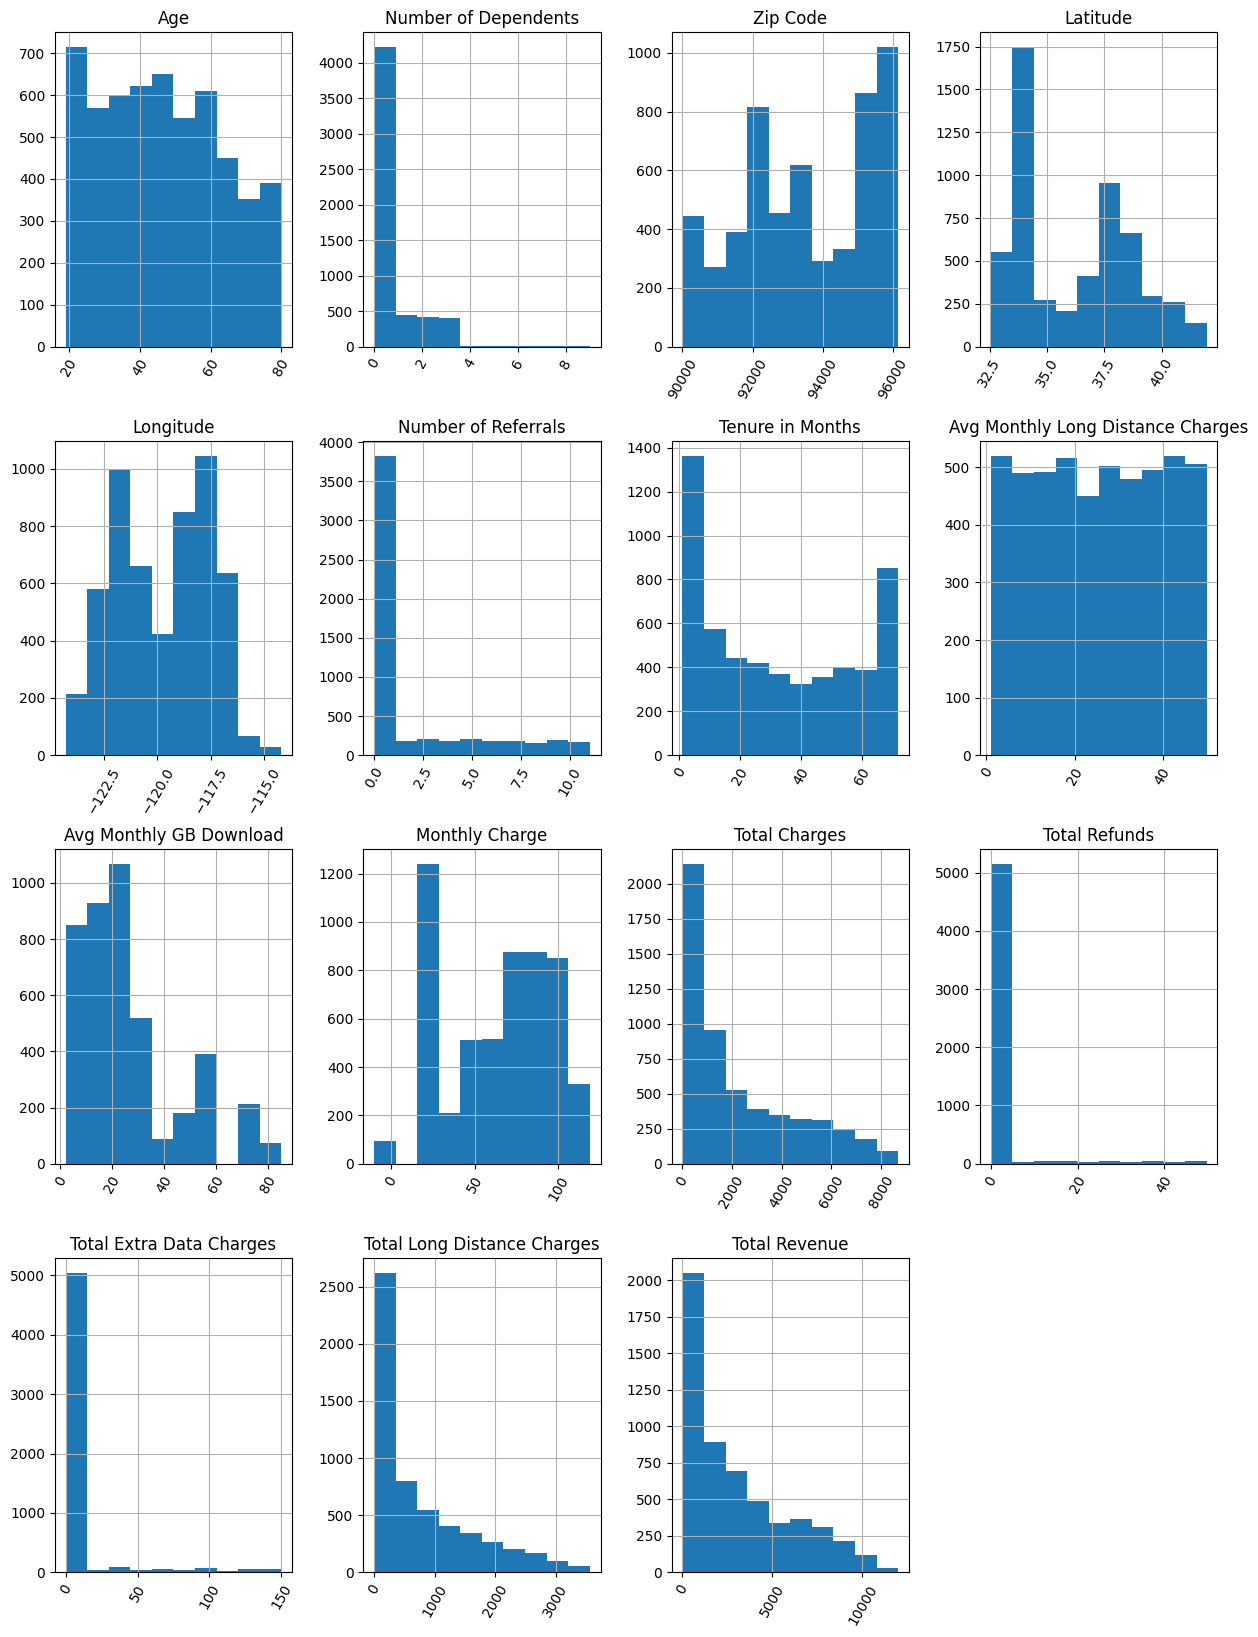

In [197]:
train_df.hist(figsize=(15, 20), xrot=60)

Đồ thị này cung cấp một cái nhìn tổng quan về nhiều khía cạnh của dữ liệu khách hàng. Phân bố độ tuổi khá đều, với số lượng cao nhất ở nhóm 20-25. Đa số khách hàng không có người phụ thuộc. Số lượng giới thiệu thấp, với đa số khách hàng không giới thiệu ai. Thời gian sử dụng dịch vụ đa dạng, phần lớn khách hàng dùng từ 0 đến 20 tháng. Phí hàng tháng tập trung ở mức trung bình (phần đông trả 20 đến 25$ một tháng). Tổng chi phí càng cao thì số lượng khác hàng càng giảm. Phí dữ liệu phụ trội và cước gọi đường dài chủ yếu ở mức thấp với hầu hết khách hàng.

### Phân tích đa biến

In [198]:
# encode customer status
class_dict = {'Stayed': 0, 'Churned': 1, 'Joined': 0}
train_df = train_df.replace({'Customer Status': class_dict})
test_df = test_df.replace({'Customer Status': class_dict})

/tmp/ipykernel_116399/1536720470.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.replace({'Customer Status': class_dict})
/tmp/ipykernel_116399/1536720470.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df = test_df.replace({'Customer Status': class_dict})


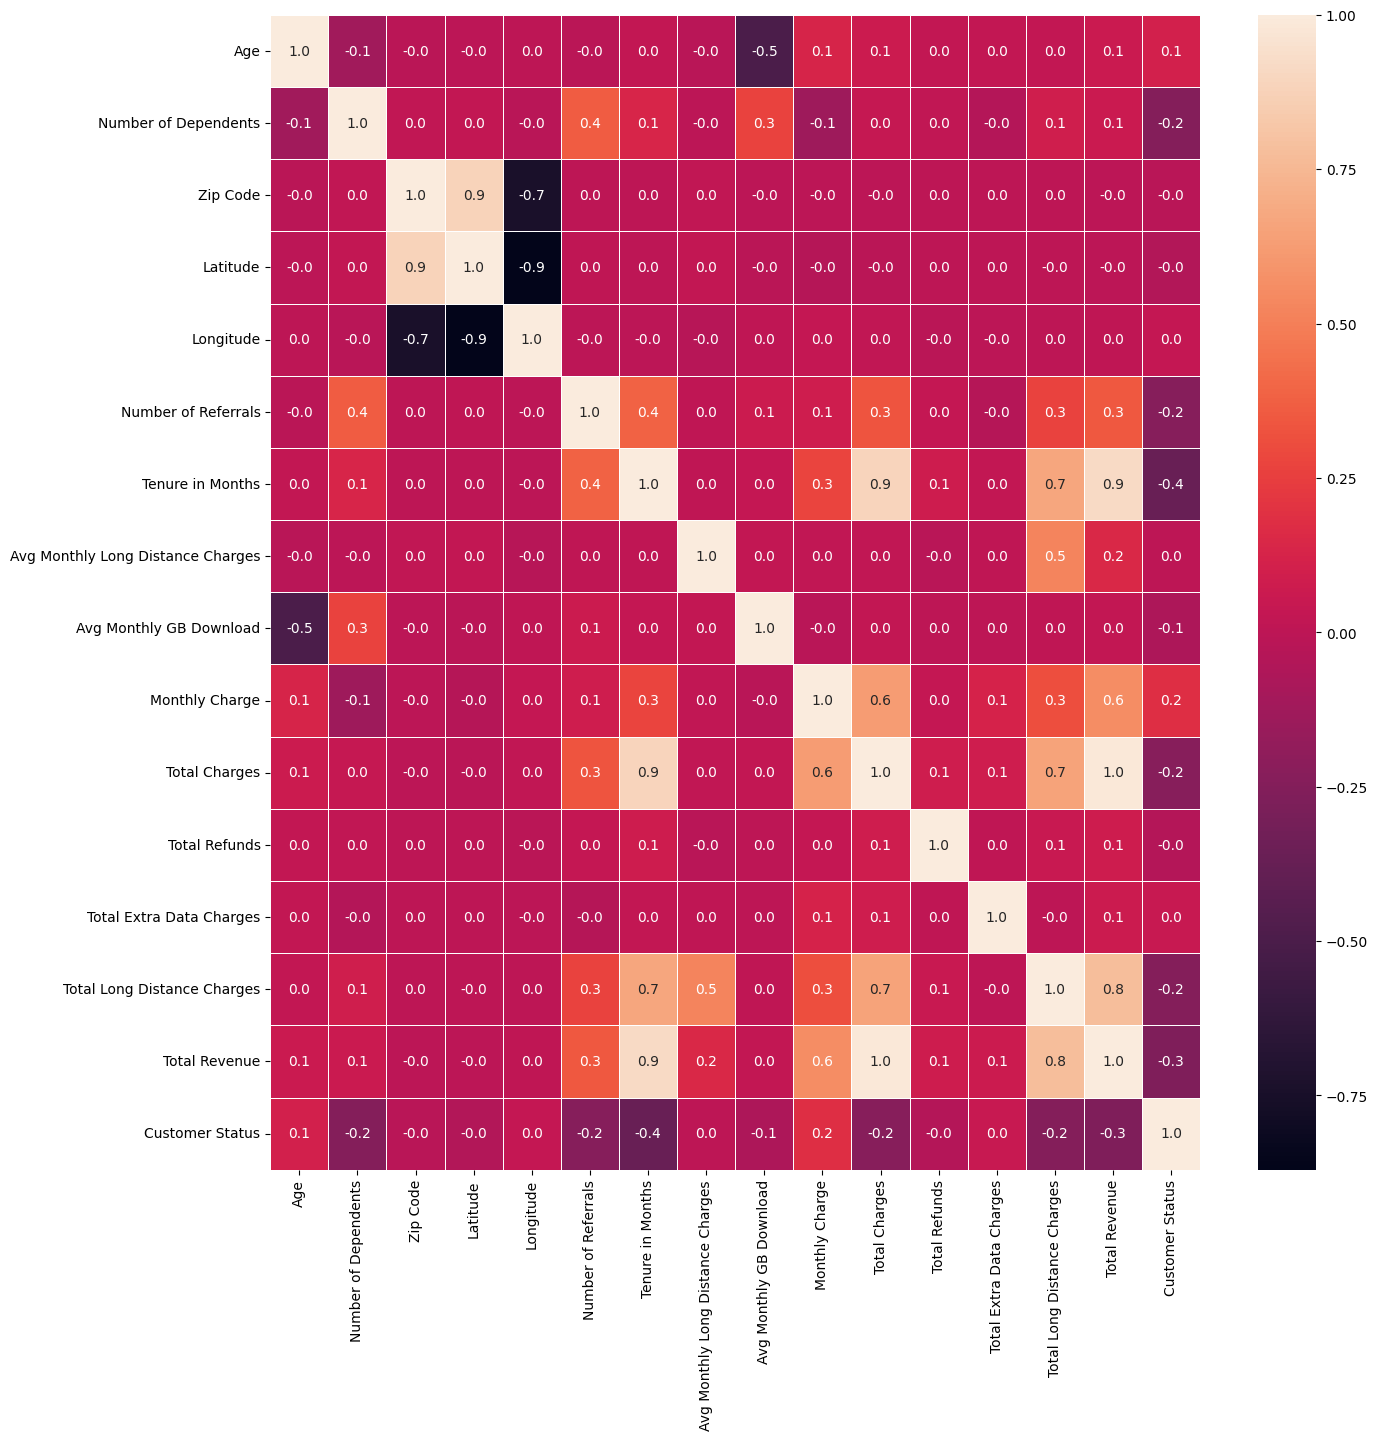

In [199]:
numeric_train_df = train_df.select_dtypes(include=[np.number])
fig, ax = plt.subplots(figsize=(15, 15))
axes = sns.heatmap(numeric_train_df.corr('spearman'), annot=True, ax=ax, linewidths=.5, fmt='.1f', cmap='rocket')

Tổng doanh thu có tương quan mạnh với tổng chi phí, thời gian sử dụng dịch vụ và cước gọi đường dài. Mã bưu điện, vĩ độ và kinh độ có mối liên hệ chặt chẽ, phản ánh vị trí địa lý. Thời gian sử dụng dịch vụ ảnh hưởng tích cực đến nhiều yếu tố như số lượng giới thiệu, chi phí hàng tháng và tổng chi phí. Thời gian ở lại tương quan âm với tình trạng khách hàng, chỉ ra rằng khách hàng càng có thâm niên thì càng ít có khả năng rời mạng.

### Trực quan hoá các thuộc tính có liên quan đến khả năng rời bỏ dịch vụ

<Axes: xlabel='Monthly Charge', ylabel='Total Charges'>

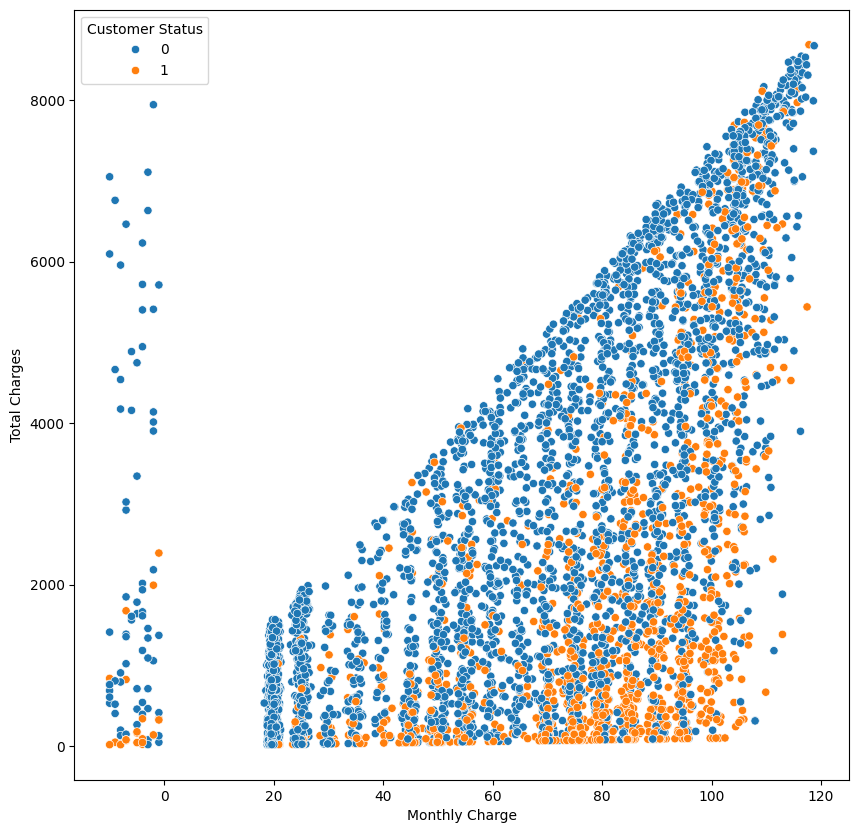

In [200]:
# scatterplot of total charge vs. monthly charge (with labels)
plt.figure(figsize=(10, 10))
sns.scatterplot(data=train_df, x='Monthly Charge', y='Total Charges', hue='Customer Status')

Khách hàng rời đi (màu cam) có xu hướng tập trung nhiều hơn ở vùng có phí hàng tháng cao hơn, đặc biệt là trong khoảng từ 60 đến 120. Khách hàng ở lại (màu xanh) phân bố đều hơn trên toàn bộ phạm vi phí hàng tháng, nhưng có vẻ chiếm ưu thế ở vùng phí thấp và trung bình. Tỷ lệ khách hàng rời đi có vẻ tăng lên khi phí hàng tháng tăng, thể hiện qua mật độ điểm màu cam cao hơn ở phía phải đồ thị.

<Axes: xlabel='Tenure in Months', ylabel='Total Charges'>

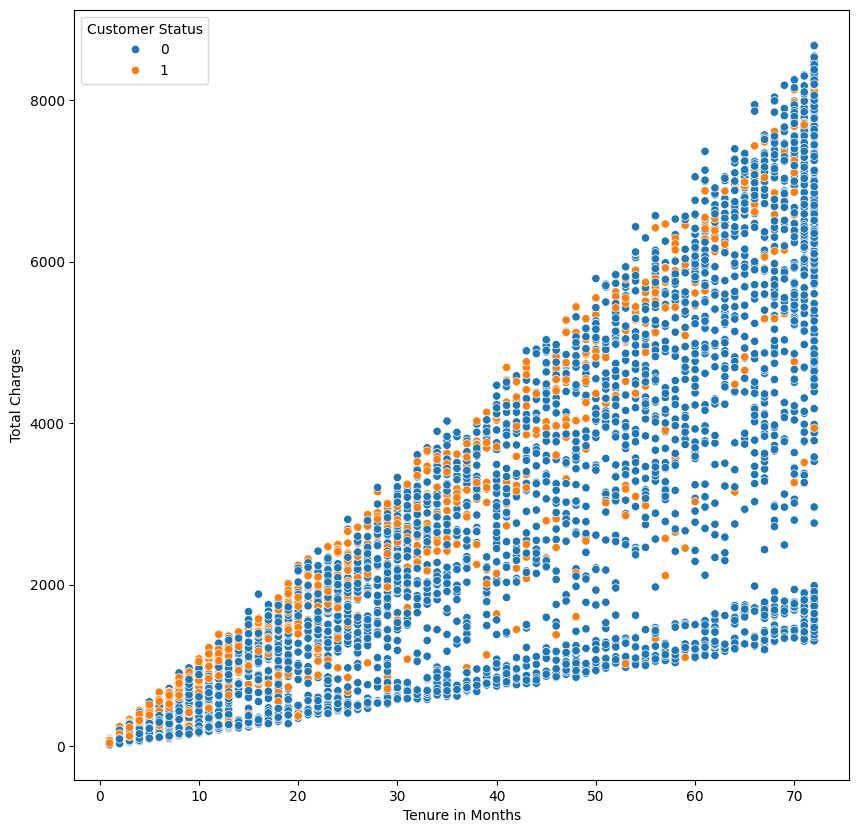

In [201]:
# scatter plot of tenure vs. total charges
plt.figure(figsize=(10, 10))
sns.scatterplot(data=train_df, x='Tenure in Months', y='Total Charges', hue='Customer Status')

Khách hàng ở lại (màu xanh) có xu hướng phân bố rộng hơn trên toàn bộ biểu đồ, cho thấy sự đa dạng trong thời gian gắn bó và tổng chi phí. Ngược lại, khách hàng rời đi (màu cam) tập trung nhiều hơn ở vùng có thời gian gắn bó ngắn hơn và tổng chi phí thấp hơn. Đáng chú ý là có một số nhóm điểm dữ liệu song song, cho thấy có thể có các gói dịch vụ hoặc mức giá khác nhau. Nhìn chung, khách hàng có thời gian gắn bó càng lâu thì tổng chi phí càng cao, nhưng nguy cơ rời đi có vẻ cao hơn trong giai đoạn đầu của dịch vụ.

<Figure size 1000x1000 with 0 Axes>

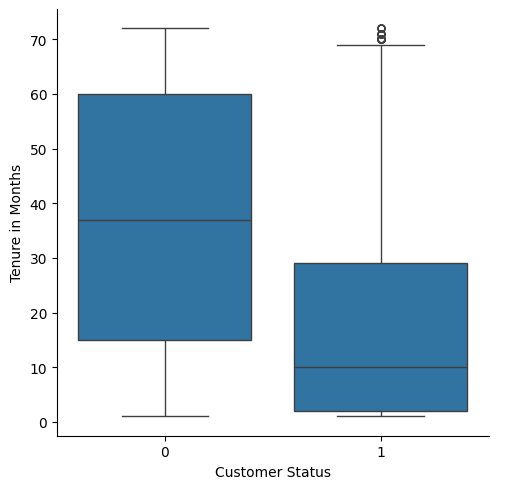

In [202]:
# boxplot of customer status vs. tenure
plt.figure(figsize=(10, 10))
sns.catplot(data=train_df, x='Customer Status', y='Tenure in Months', kind='box')

Khách hàng ở lại có thời gian gắn bó trung bình cao hơn (khoảng 37 tháng) và phạm vi rộng hơn (từ 15 đến 60 tháng). Ngược lại, khách hàng rời đi có thời gian gắn bó trung bình ngắn hơn nhiều (khoảng 10 tháng) và tập trung chủ yếu trong khoảng 3 đến 30 tháng. Điều này cho thấy khách hàng có khả năng rời đi cao nhất trong những tháng đầu. Tuy nhiên, vẫn có một số khách hàng rời đi sau thời gian dài gắn bó (thể hiện qua các điểm ngoại lệ).

<Figure size 1000x1000 with 0 Axes>

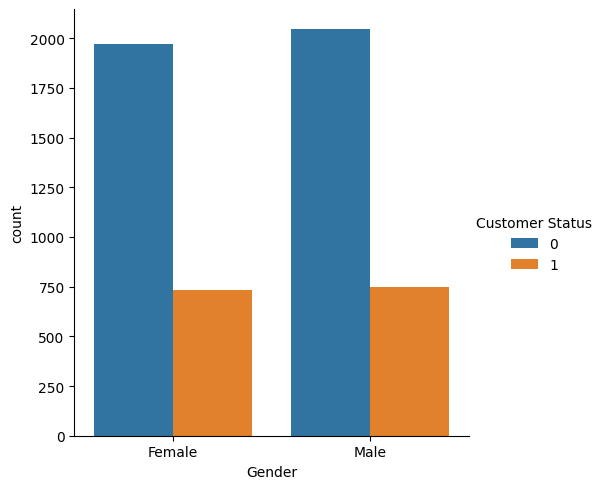

In [203]:
# barplot of gender vs count of customer status
plt.figure(figsize=(10, 10))
sns.catplot(data=train_df, x='Gender', hue='Customer Status', kind='count')

Số lượng khách hàng nam và nữ khá cân bằng, với nam giới có chút ít nhiều hơn. Tỷ lệ khách hàng rời đi so với ở lại cũng tương đối đồng đều giữa hai giới.

<Figure size 1000x1000 with 0 Axes>

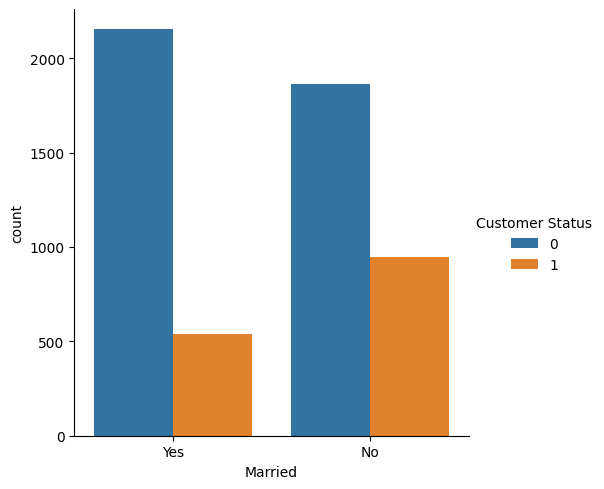

In [204]:
# barplot of married vs count of customer status
plt.figure(figsize=(10, 10))
sns.catplot(data=train_df, x='Married', hue='Customer Status', kind='count')

Đối với khách hàng đã kết hôn, số lượng khách hàng ở lại (màu xanh) cao hơn đáng kể so với khách hàng rời đi (màu cam). Tuy nhiên, đối với khách hàng chưa kết hôn, sự chênh lệch này ít rõ rệt hơn, với tỷ lệ khách hàng rời đi cao hơn. Điều này gợi ý rằng khách hàng đã kết hôn có xu hướng trung thành hơn với dịch vụ. 

<Figure size 1000x1000 with 0 Axes>

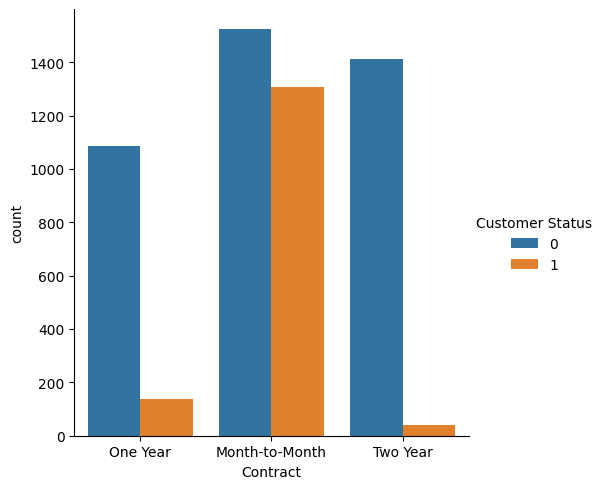

In [205]:
# barplot of contact vs count of customer status
plt.figure(figsize=(10, 10))
sns.catplot(data=train_df, x='Contract', hue='Customer Status', kind='count')

Đối với hợp đồng Month-to-Month, tỷ lệ khách hàng rời đi (màu cam) cao nhất và gần bằng số khách hàng ở lại (màu xanh), cho thấy đây là nhóm có nguy cơ mất khách hàng cao nhất. Ngược lại, hợp đồng One Year và Two Year có tỷ lệ khách hàng ở lại rất cao, đặc biệt là Two Year gần như không có khách hàng rời đi. Điều này chỉ ra rằng các hợp đồng dài hạn hiệu quả hơn trong việc giữ chân khách hàng.

<Figure size 1000x1000 with 0 Axes>

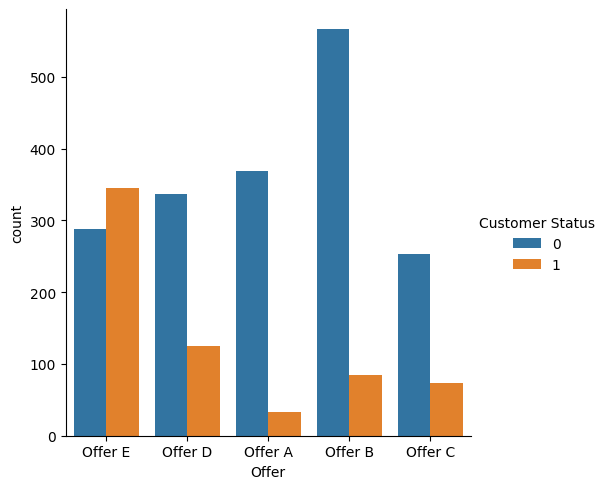

In [206]:
# barplot of offer vs count of customer status
plt.figure(figsize=(10, 10))
sns.catplot(data=train_df, x='Offer', hue='Customer Status', kind='count')

Biểu đồ cột này so sánh số lượng khách hàng theo các loại ưu đãi (Offer) khác nhau. Offer B có số lượng khách hàng ở lại (màu xanh) cao nhất và tỷ lệ khách hàng rời đi thấp, cho thấy đây là ưu đãi hiệu quả nhất trong việc giữ chân khách hàng. Ngược lại, Offer E có số lượng khách hàng rời đi (màu cam) cao hơn số khách hàng ở lại, chỉ ra rằng đây là ưu đãi kém hiệu quả nhất. Offer A, C và D có tỷ lệ giữ chân khách hàng tốt, với số lượng khách hàng ở lại vượt trội so với số rời đi

## 4. Xử lý dữ liệu

### Xử lý thuộc tính địa lý

Nỗi bảng train với bảng dữ liệu về zip code và mật độ dân số

In [207]:
def merge_zipcode(df):
    df['Zip Code'] = df['Zip Code'].astype(str)
    zip_df['zip'] = zip_df['zip'].astype(str)

    df_merged = pd.merge(df, zip_df, left_on='Zip Code', right_on='zip', how='left')

    unmatched = df_merged[df_merged['density'].isna()]
    print(f"Number of unmatched Zip codes: {len(unmatched)}")
    return df_merged

In [208]:
# Concatenate geographical data -> population density
train_df = merge_zipcode(train_df)
test_df = merge_zipcode(test_df)

Number of unmatched Zip codes: 4
Number of unmatched Zip codes: 0


In [209]:
def categorize_location(density):
    if density < 100:
        return 'Rural'
    #elif density < 500:
        #return 'Suburban'
    #elif density < 2000:
        #return 'Urban'
    else:
        return 'Urban'

In [210]:
#train_df['Location Type'] = train_df['density'].apply(categorize_location)
#test_df['Location Type'] = test_df['density'].apply(categorize_location)

### Xử lý dữ liệu bị thiếu

In [211]:
train_df.isnull().sum().sort_values(ascending=False)

Churn Category                       4018
Churn Reason                         4018
Offer                                3028
Device Protection Plan               1194
Streaming TV                         1194
Premium Tech Support                 1194
Online Security                      1194
Online Backup                        1194
Streaming Movies                     1194
Streaming Music                      1194
Avg Monthly GB Download              1194
Internet Type                        1194
Unlimited Data                       1194
Avg Monthly Long Distance Charges     526
Multiple Lines                        526
zip                                     4
density                                 4
Zip Code                                0
City                                    0
Number of Dependents                    0
Married                                 0
Age                                     0
Gender                                  0
Customer ID                       

In [212]:
def process_missing_value(df):
    # process avg monthly long distance charges and multiple lines
    df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(0)
    df['Multiple Lines'] = df['Multiple Lines'].fillna("No")
    
    # process Internet service
    service_cols = ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']
    df[service_cols] = df[service_cols].fillna("No")
    df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].fillna(0)

    # Create 'No Offer' category (high absence percentage suggests that absence might be meaningful)
    df['Offer'] = df['Offer'].fillna('No Offer')

    df['density'] = df['density'].fillna(df['density'].median())

In [213]:
process_missing_value(train_df)
process_missing_value(test_df)

In [214]:
train_df.isnull().sum().sort_values(ascending=False)

Churn Category                       4018
Churn Reason                         4018
Internet Type                        1194
zip                                     4
Customer ID                             0
Gender                                  0
Age                                     0
Married                                 0
Latitude                                0
Zip Code                                0
City                                    0
Number of Dependents                    0
Phone Service                           0
Longitude                               0
Tenure in Months                        0
Number of Referrals                     0
Internet Service                        0
Avg Monthly GB Download                 0
Online Security                         0
Online Backup                           0
Device Protection Plan                  0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Offer                             

### Hợp nhất các thuộc tính về dịch vụ Internet

In [215]:
internet_service = [
    'Online Security',
    'Online Backup',
    'Device Protection Plan',
    'Premium Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Streaming Music',
    'Unlimited Data'
]

In [216]:
def count_services(row):
    return sum(row[service] == 'Yes' for service in internet_service)

In [217]:
train_df['Number of Services'] = train_df.apply(count_services, axis=1)
test_df['Number of Services'] = test_df.apply(count_services, axis=1)

### Bỏ đi những thuộc tính thừa

In [218]:
def remove_unwanted_columns(df):
    unwanted_cols = ['Customer ID', 'Zip Code', 'City', 'Latitude', 'Longitude', 'Customer Status', 'Churn Reason', 'Churn Category', 'zip']
    # concatenate internet services
    for service in internet_service:
        unwanted_cols.append(service)
    return df.drop(columns=unwanted_cols)


In [219]:
x_train_raw = remove_unwanted_columns(train_df)
y_train = train_df['Customer Status']

x_test_raw = remove_unwanted_columns(test_df)
y_test = test_df['Customer Status']

In [220]:
print('training shape', x_train_raw.shape)
print('test shape', x_test_raw.shape)

training shape (5500, 24)
test shape (1543, 24)


In [221]:
for att in x_train_raw.columns:
    print(att, x_train_raw[att].unique())

Gender ['Female' 'Male']
Age [37 46 50 78 75 23 67 52 68 43 47 25 58 32 39 72 79 26 30 22 34 42 64 48
 28 33 31 60 69 20 57 19 38 54 35 51 66 61 24 55 59 71 49 40 21 45 29 62
 76 77 73 41 56 80 63 53 44 70 74 36 27 65]
Married ['Yes' 'No']
Number of Dependents [0 3 1 2 4 6 5 9 7 8]
Number of Referrals [ 2  0  1  3  8  9 10  5  4  7  6 11]
Tenure in Months [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
Offer ['No Offer' 'Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']
Phone Service ['Yes' 'No']
Avg Monthly Long Distance Charges [42.39 10.69 33.65 ...  7.25 43.83 12.91]
Multiple Lines ['No' 'Yes']
Internet Service ['Yes' 'No']
Internet Type ['Cable' 'Fiber Optic' 'DSL' nan]
Avg Monthly GB Download [16. 10. 30.  4. 11. 73. 14.  7. 21. 59. 19. 12. 20. 22. 17.  9.  0. 52.
 57. 51. 41. 23. 27.  2. 69. 53. 15. 29. 85. 28

### Thuộc tính phân loại nhị phân

In [222]:
def is_binary_attribute(series):
    unique_values = series.dropna().unique()
    return unique_values.size == 2

In [223]:
binary_attributes = [col for col in x_train_raw.columns if is_binary_attribute(train_df[col])]
binary_attributes

['Gender',
 'Married',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Paperless Billing']

In [224]:
label_encoder = LabelEncoder()

for col in binary_attributes:
    x_train_raw[col] = label_encoder.fit_transform(x_train_raw[col])
    x_test_raw[col] = label_encoder.fit_transform(x_test_raw[col])

In [225]:
x_train_raw[binary_attributes].head()

,Gender,Married,Phone Service,Multiple Lines,Internet Service,Paperless Billing
0,0,1,1,0,1,1
1,1,0,1,1,1,0
2,1,0,1,0,1,1
3,1,1,1,0,1,1
4,0,1,1,0,1,1


### Thuộc tính phân loại (> 2 giá trị)

In [226]:
columns_to_onehot = ['Offer', 'Internet Type', 'Contract', 'Payment Method']#, 'Location Type']

In [227]:
def encode_categorical_feature(df, columns):
    ohe = OneHotEncoder(sparse_output=False)
    encoded_cols = ohe.fit_transform(df[columns])
    new_cols_name = ohe.get_feature_names_out(columns)
    encoded_df = pd.DataFrame(encoded_cols, columns=new_cols_name, index=df.index)
    df = pd.concat([df.drop(columns=columns, axis=1), encoded_df], axis=1)
    return df

In [228]:
x_train_raw = encode_categorical_feature(x_train_raw, columns_to_onehot)
x_test_raw = encode_categorical_feature(x_test_raw, columns_to_onehot)

In [229]:
x_train_raw.head()

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Paperless Billing,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,density,Number of Services,Offer_No Offer,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_nan,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,0,37,1,0,2,9,1,42.39,0,1,16.0,1,65.6,593.30,0.00,0,381.51,974.81,17.3,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,46,0,0,0,9,1,10.69,1,1,10.0,0,-4.0,542.40,38.33,10,96.21,610.28,2163.4,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,50,0,0,0,4,1,33.65,0,1,30.0,1,73.9,280.85,0.00,0,134.60,415.45,3752.3,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,78,1,0,1,13,1,27.82,0,1,4.0,1,98.0,1237.85,0.00,0,361.66,1599.51,307.3,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,75,1,0,3,3,1,7.38,0,1,11.0,1,83.9,267.40,0.00,0,22.14,289.54,837.4,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Thuộc tính số nguyên

In [230]:
scaler = MinMaxScaler(feature_range=(0, 1))

integral_attribute = ['Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'density', 'Number of Services']

x_train_raw[integral_attribute] = scaler.fit_transform(x_train_raw[integral_attribute])
x_test_raw[integral_attribute] = scaler.fit_transform(x_test_raw[integral_attribute])

In [231]:
x_train_raw[integral_attribute].head()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,density,Number of Services
0,0.295082,0.0,0.181818,0.112676,0.000836,0.500
1,0.442623,0.0,0.000000,0.112676,0.104593,0.250
2,0.508197,0.0,0.000000,0.042254,0.181411,0.250
3,0.967213,0.0,0.090909,0.169014,0.014857,0.625
4,0.918033,0.0,0.272727,0.028169,0.040485,0.375


### Thuộc tính số thực

In [232]:
float_attribute = ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds','Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']

scaler = MinMaxScaler(feature_range=(0, 1))

train_df[float_attribute] = scaler.fit_transform(train_df[float_attribute])
test_df[float_attribute] = scaler.fit_transform(test_df[float_attribute])

In [233]:
train_df[float_attribute].head()

,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,0.847970,0.188235,0.587184,0.066294,0.000000,0.000000,0.107024,0.079730
1,0.213843,0.117647,0.046602,0.060420,0.769833,0.066667,0.026989,0.049246
2,0.673135,0.352941,0.651650,0.030239,0.000000,0.000000,0.037759,0.032953
3,0.556511,0.047059,0.838835,0.140670,0.000000,0.000000,0.101455,0.131972
4,0.147630,0.129412,0.729320,0.028687,0.000000,0.000000,0.006211,0.022424


### SMOTE

In [234]:
smote = SMOTE(random_state=42)
x_train_raw_balanced, y_train_balanced = smote.fit_resample(x_train_raw, y_train)

print("Before SMOTE: ", y_train.value_counts())
print("After SMOTE: ", y_train_balanced.value_counts())

Before SMOTE:  Customer Status
0    4018
1    1482
Name: count, dtype: int64
After SMOTE:  Customer Status
0    4018
1    4018
Name: count, dtype: int64


## 5. Phân cụm

Phân đoạn có nghĩa là chia tổng thị trường khách hàng thành các nhóm nhỏ hơn, tương đối đồng nhất. Giai đoạn này cố gắng nhóm các cá nhân sao cho những người trong mỗi nhóm chia sẻ các đặc điểm tương tự.

Điều này hữu ích vì mục tiêu của các nhà tiếp thị là tăng số lượng bán hàng, và để làm điều đó họ sẽ cần tạo ra một chiến lược tiếp thị tùy chỉnh cho mỗi cá nhân, điều này không thực tế và không thể! Giải pháp tốt nhất tiếp theo là nhóm các cá nhân thành các nhóm tương tự nhau để giảm số lượng chiến lược tiếp thị, đồng thời tiếp cận được nhiều người nhất có thể!

Để làm điều này, các nhà phân tích tiếp thị sử dụng Phân tích Cụm (Cluster Analysis) để nhóm khách hàng theo cách giảm thiểu phương sai trong cụm và tối đa hóa phương sai giữa các cụm.

chúng tôi muốn giảm thiểu Tỷ lệ Churn (Churn Rates). Do đó, chúng tôi sẽ nhóm các cá nhân thành các cụm và lập hồ sơ cho họ. Tìm ra các cụm có tỷ lệ Churn đáng chú ý cao hơn để doanh nghiệp có thể tạo ra các chiến lược tiếp thị để giữ chân những cá nhân trong các cụm đó.

### K-mean

In [235]:
x_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             5500 non-null   int64  
 1   Age                                5500 non-null   float64
 2   Married                            5500 non-null   int64  
 3   Number of Dependents               5500 non-null   float64
 4   Number of Referrals                5500 non-null   float64
 5   Tenure in Months                   5500 non-null   float64
 6   Phone Service                      5500 non-null   int64  
 7   Avg Monthly Long Distance Charges  5500 non-null   float64
 8   Multiple Lines                     5500 non-null   int64  
 9   Internet Service                   5500 non-null   int64  
 10  Avg Monthly GB Download            5500 non-null   float64
 11  Paperless Billing                  5500 non-null   int64

Câu hỏi chính dẫn dắt phân tích này là: “Các phân khúc khách hàng riêng biệt trong cơ sở khách hàng của công ty viễn thông là gì?” Mục tiêu là hiểu rõ hơn về những điểm tương đồng và khác biệt giữa các nhóm khách hàng khác nhau, từ đó tạo điều kiện cho các chiến lược kinh doanh nhắm đến đối tượng cụ thể và hiệu quả hơn.

In [236]:
df_clustering = x_train_raw[['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Revenue']]


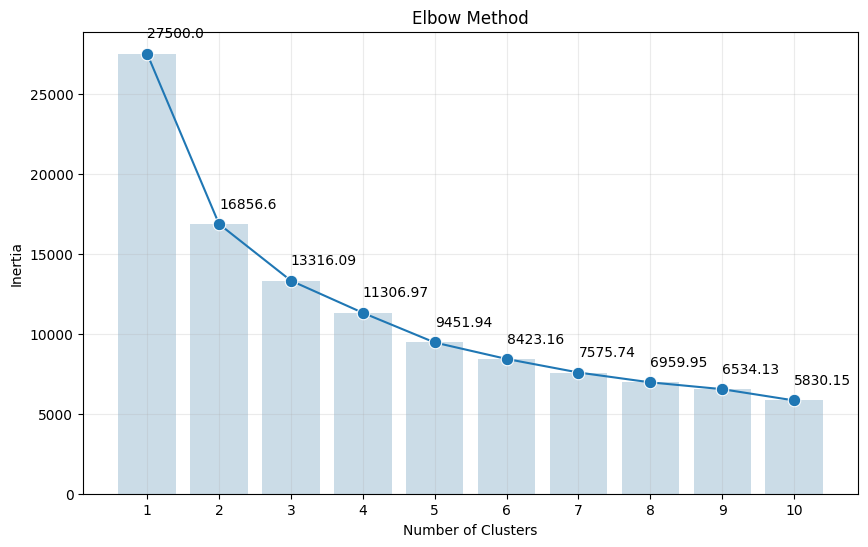

In [237]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_clustering)

inertia = np.array([])
k_vals = range(1, 11)

for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(scaled_df)
    inertia = np.append(inertia, kmeans.inertia_)

# Tạo DataFrame cho các giá trị inertia
inertia_vals = pd.DataFrame(inertia, index=k_vals, columns=['Inertia'])

# Vẽ đồ thị phương pháp Elbow
plt.figure(figsize=(10, 6))
sns.barplot(x=inertia_vals.index, y=inertia_vals.Inertia, alpha=0.25)
sns.lineplot(x=inertia_vals.index-1, y=inertia_vals.Inertia, marker='o', markersize=9, legend=False)
plt.title('Elbow Method')
plt.xticks(inertia_vals.index-1)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
for i in inertia_vals.index:
    plt.text(
        x=i-1, 
        y=inertia_vals.Inertia[i]+1000, 
        s=round(inertia_vals.Inertia[i], 2)
    )
plt.grid(alpha=0.25)
plt.show()

Từ đồ thị Elbow thì ta có thể lựa chọn được điểm "Khủy tay" nằm ở k = 2

In [238]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(scaled_df)

## Get the predicted labels
predicted_labels = kmeans.fit_predict(scaled_df)
## Calculate the silhouette score
silhouette = silhouette_score(scaled_df, predicted_labels)
print(f'Silhouette Score: {silhouette}, {n_clusters} clusters')


Silhouette Score: 0.3658914541913219, 2 clusters


In [239]:
df_clustering['Cluster'] = kmeans.labels_ + 1

/tmp/ipykernel_116399/662542925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['Cluster'] = kmeans.labels_ + 1


In [240]:
## Calculate cluster summary
cluster_summary = df_clustering.groupby('Cluster').agg(['mean', 'median', 'std']).transpose()
cluster_summary.columns = ['Cluster 1', 'Cluster 2']
cluster_summary

Cluster 1    Cluster 2
Avg Monthly Long Distance Charges mean      26.736759    21.329949
                                  median    27.410000    20.110000
                                  std       14.517890    15.664080
Avg Monthly GB Download           mean      28.213844    16.860596
                                  median    22.000000    12.000000
                                  std       20.899841    19.215307
Monthly Charge                    mean      91.242403    50.465700
                                  median    94.350000    50.150000
                                  std       17.053291    27.715518
Total Charges                     mean    5101.005431   923.768920
                                  median  5016.250000   679.850000
                                  std     1585.676853   861.598905
Total Revenue                     mean    6558.258509  1342.603591
                                  median  6507.000000  1020.000000
                                  std     2001.215902  1190.178959

In [241]:
## Get centroids
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    index=['Cluster 1', 'Cluster 2'], 
    columns=df_clustering.columns[:-1]
)
print('Cluster centroids:\n')
for i in centroids.index:
    print(i)
    for col in centroids.columns:
        print(f'{col}: {round(centroids[col][i], 2)}')
    print()

Cluster centroids:

Cluster 1
Avg Monthly Long Distance Charges: 26.73
Avg Monthly GB Download: 28.25
Monthly Charge: 91.23
Total Charges: 5097.77
Total Revenue: 6553.95

Cluster 2
Avg Monthly Long Distance Charges: 21.33
Avg Monthly GB Download: 16.84
Monthly Charge: 50.45
Total Charges: 923.07
Total Revenue: 1341.86



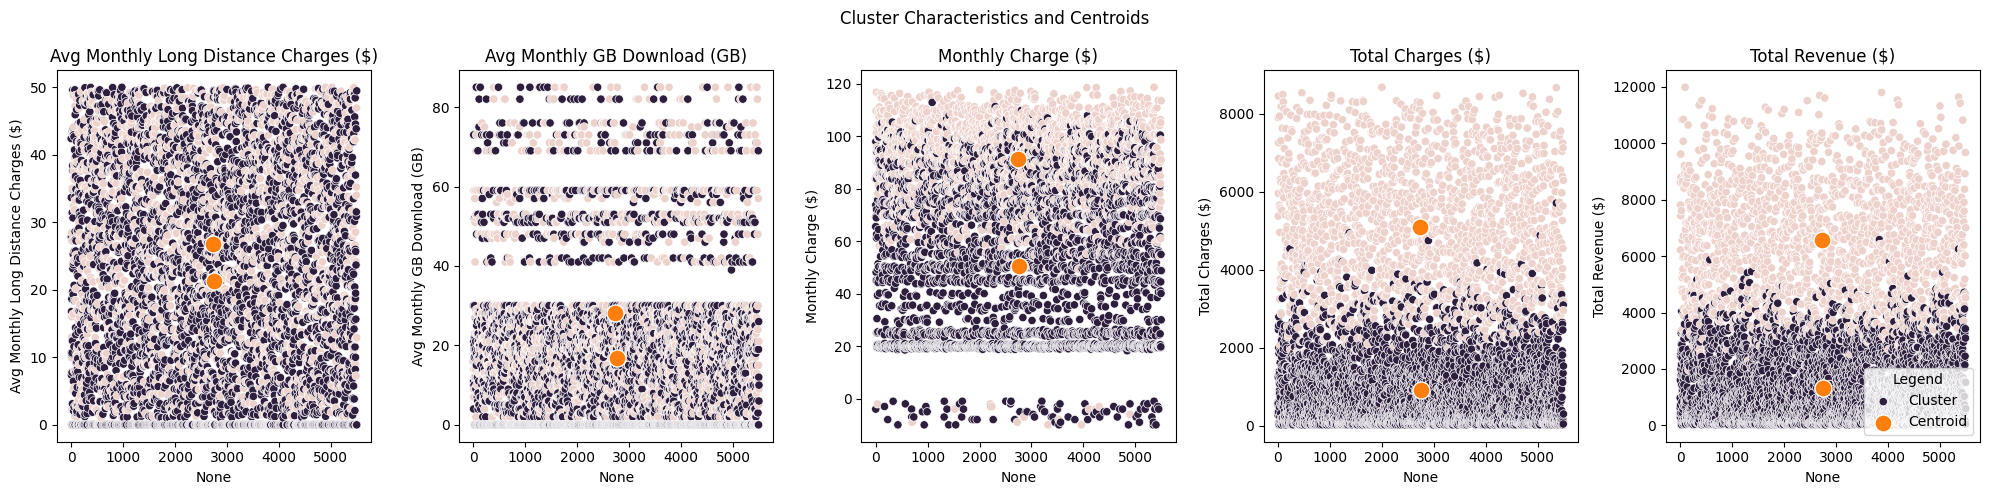

In [242]:
## Plot centroids
centr_x = [sum(df_clustering[df_clustering.Cluster==1].index)/len(df_clustering[df_clustering.Cluster==1]), sum(df_clustering[df_clustering.Cluster==2].index)/len(df_clustering[df_clustering.Cluster==2])]
titles = [
  'Avg Monthly Long Distance Charges ($)', 
    'Avg Monthly GB Download (GB)', 
    'Monthly Charge ($)', 
    'Total Charges ($)', 
    'Total Revenue ($)'
]
y_labels = [
     'Avg Monthly Long Distance Charges ($)', 
    'Avg Monthly GB Download (GB)', 
    'Monthly Charge ($)', 
    'Total Charges ($)', 
    'Total Revenue ($)'
]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
plt.suptitle('Cluster Characteristics and Centroids')
for i in range(5):
    sns.scatterplot(x=df_clustering.index, y=df_clustering[df_clustering.columns[i]], hue=df_clustering.Cluster, ax=ax[i], legend=False)
    sns.scatterplot(x=centr_x, y=centroids[centroids.columns[i]], s=150, ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_ylabel(y_labels[i])
ax[4].legend(['Cluster', 'Centroid'], title='Legend', loc='lower right')
plt.tight_layout()

Nhìn chung thì ta có thể thấy rằng 2 cụm dữ liệu có tượng tự nhau về chi phí gọi đường dài cũng như lượng GB sử dụng hằng tháng, tuy nhiên thì cụm 1 có phí phải trả hằng tháng cao hơn cụm 2, điều này có thể giải thích ở các dịch vụ kèm theo

## 6. Lựa chọn thuộc tính

In [46]:
x_train_raw.columns
print(x_train_raw.columns)

Index(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Avg Monthly GB Download', 'Paperless Billing',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'density', 'Number of Services', 'Offer_No Offer',
       'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D',
       'Offer_Offer E', 'Internet Type_Cable', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_nan',
       'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year',
       'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card',
       'Payment Method_Mailed Check'],
      dtype='object')


In [47]:
def plot_feature_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Correlation

In [48]:
def get_corr_features(df):
    """
    Get features with correlation > 0.1
    :param df: dataframe with numeric features
    :return:
    """
    corr_feat = list(df.corr()[abs(df.corr()['Customer Status']) > 0.1].index)
    corr_feat.remove('Customer Status')
    return corr_feat

In [49]:
train_numeric = pd.concat([x_train_raw, y_train], axis=1)

corr_feat = get_corr_features(train_numeric)

In [50]:
print(corr_feat)

['Age', 'Married', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Internet Service', 'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer E', 'Internet Type_Fiber Optic', 'Internet Type_nan', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card']


### Annova

In [51]:
def get_annova_features(df):
    """
    Get features with ANNOVA > 0.1
    :param df: dataframe with numeric features
    :return:
    """
    annova_scores, _ = f_classif(np.abs(df.values), y_train)
    annova_feats_score = list(zip(df.columns, annova_scores))
    annova_feats_score.sort(key=lambda x: -x[1])
    # choose top 20 features
    annova_feats = [i[0] for i in annova_feats_score[:20]]
    annova_feats.remove('Customer Status')
    plot_feature_importance(
        [i[1] for i in annova_feats_score],
        [i[0] for i in annova_feats_score],
        'Annova'
    )
    return annova_feats

/home/huu_phuc/.local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


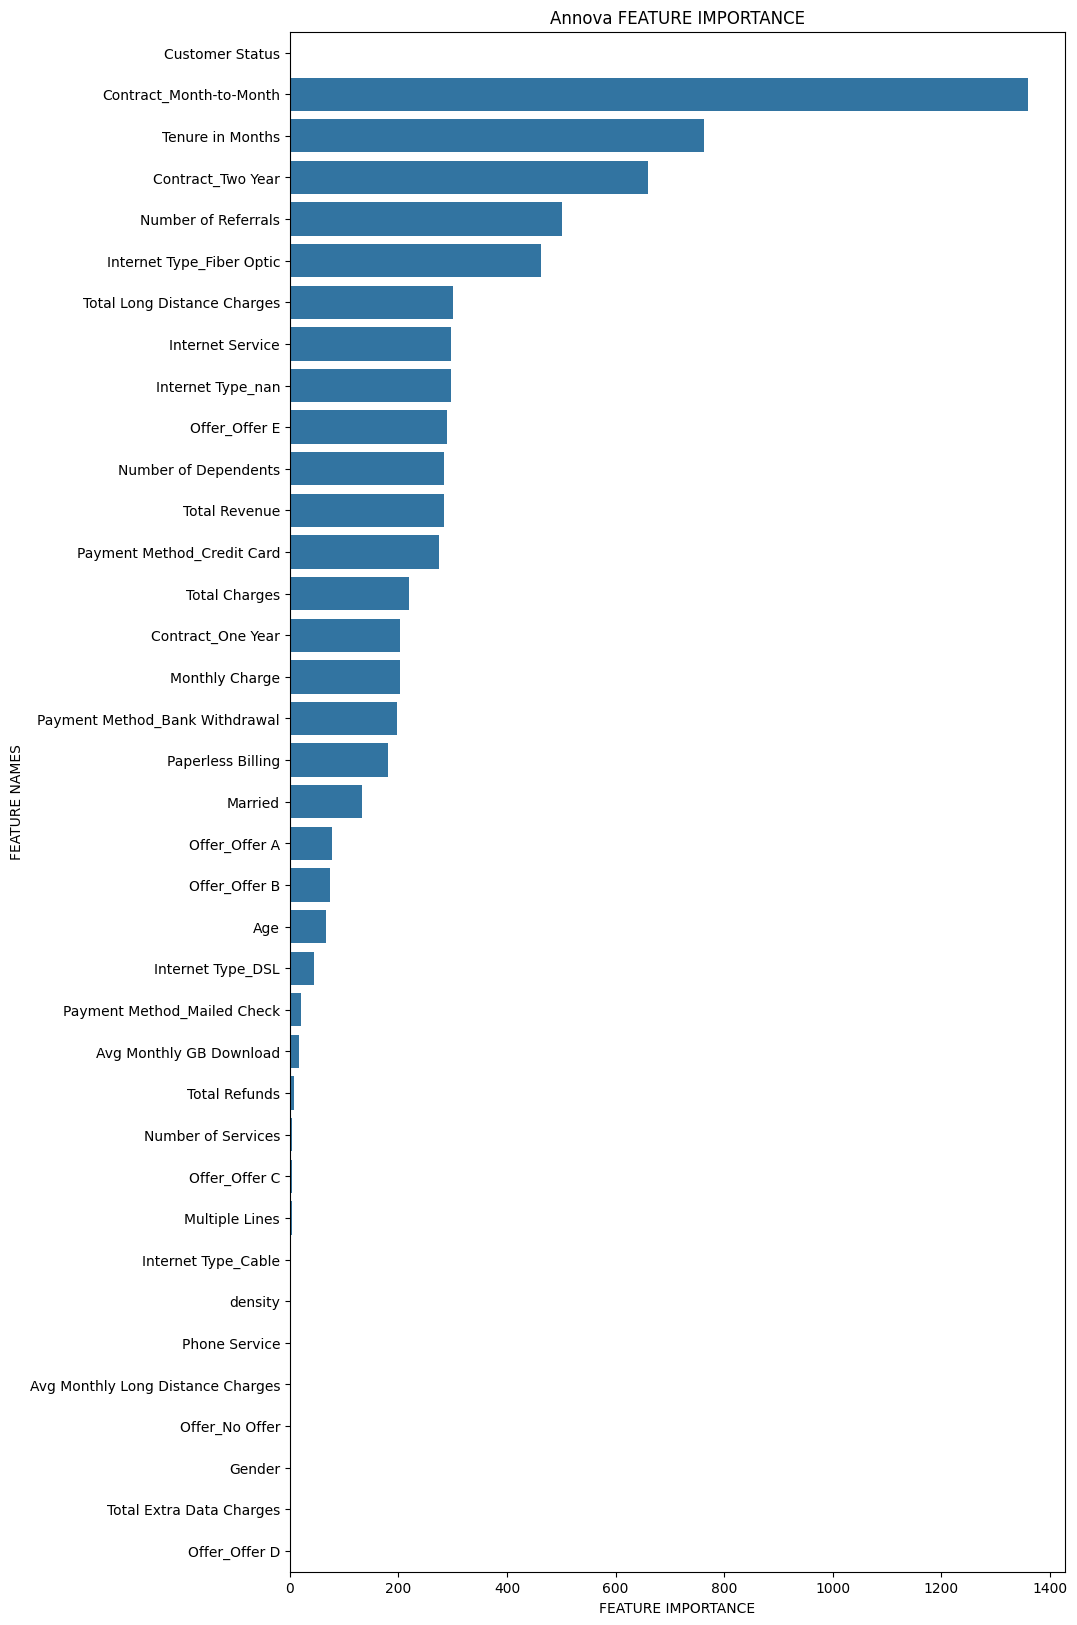

In [52]:
annova_feats = get_annova_features(train_numeric)

### Mutual Information

In [53]:
mi_selector = SelectKBest(mutual_info_classif, k=20)
mi_selector.fit(x_train_raw, y_train)
mi_score = pd.DataFrame({"feature": x_train_raw.columns, "score": mi_selector.scores_}).sort_values("score", ascending=False)
print("Top features by mutual information:")
print(mi_score)

Top features by mutual information:
                              feature     score
30            Contract_Month-to-Month  0.107227
4                 Number of Referrals  0.078683
5                    Tenure in Months  0.075937
32                  Contract_Two Year  0.065216
19                 Number of Services  0.054643
16        Total Long Distance Charges  0.051208
28          Internet Type_Fiber Optic  0.049835
12                     Monthly Charge  0.048274
13                      Total Charges  0.041990
10            Avg Monthly GB Download  0.039701
3                Number of Dependents  0.039039
29                  Internet Type_nan  0.035144
17                      Total Revenue  0.034179
18                            density  0.034015
9                    Internet Service  0.030400
11                  Paperless Billing  0.025401
27                  Internet Type_DSL  0.021854
25                      Offer_Offer E  0.020687
33     Payment Method_Bank Withdrawal  0.018255
34  

### Random Forest feature

In [1039]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(x_train_raw, y_train)
feature_importance = pd.DataFrame({"feature": x_train_raw.columns, "importance": rf_classifier.feature_importances_}).sort_values("importance", ascending=False)
print("Top features by random forest:")
print(feature_importance.head(20))

Top features by random forest:
                              feature  importance
30            Contract_Month-to-Month    0.083144
12                     Monthly Charge    0.079464
1                                 Age    0.074015
13                      Total Charges    0.073266
5                    Tenure in Months    0.071919
17                      Total Revenue    0.068967
4                 Number of Referrals    0.063020
18                            density    0.057998
16        Total Long Distance Charges    0.055714
10            Avg Monthly GB Download    0.051114
7   Avg Monthly Long Distance Charges    0.050312
32                  Contract_Two Year    0.032784
19                 Number of Services    0.029605
3                Number of Dependents    0.026309
28          Internet Type_Fiber Optic    0.025563
34         Payment Method_Credit Card    0.015191
31                  Contract_One Year    0.011680
15           Total Extra Data Charges    0.011602
11                 

In [1040]:
# Select top 20 features based on Random Forest
top_features = feature_importance.head(20)["feature"].values
x_train = x_train_raw[top_features]
#x_test = x_test_raw[top_features]
print(top_features)

['Contract_Month-to-Month' 'Monthly Charge' 'Age' 'Total Charges'
 'Tenure in Months' 'Total Revenue' 'Number of Referrals' 'density'
 'Total Long Distance Charges' 'Avg Monthly GB Download'
 'Avg Monthly Long Distance Charges' 'Contract_Two Year'
 'Number of Services' 'Number of Dependents' 'Internet Type_Fiber Optic'
 'Payment Method_Credit Card' 'Contract_One Year'
 'Total Extra Data Charges' 'Paperless Billing' 'Married']


## 7. Mô hình phân lớp

### Hàm đánh giá kết quả

In [1041]:
# Evaluate model accuracy
def evaluate(model, x_test, y_test):
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    print("ACC: ", acc)
    print(classification_report(y_test,pred))


# Visualize confusion matrix
def visualize_result(model, x_test, y_test):
    y_pred = model.predict(x_test)
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap='Blues',annot=True,linewidths=2,linecolor='white')

### Features

In [1042]:
x_train_raw_balanced = x_train_raw_balanced[annova_feats]
x_test_raw = x_test_raw[annova_feats]

### Sử dụng toàn bộ feature

In [1043]:
# Scaling data using standard scaler

scaler = StandardScaler()
scaler.fit(x_train_raw_balanced)
x_train_scaled = scaler.transform(x_train_raw_balanced)
x_test_scaled = scaler.transform(x_test_raw)

print('training shape: ', x_train_scaled.shape)
print('testing shape: ', x_test_scaled.shape)

training shape:  (8036, 19)
testing shape:  (1543, 19)


### Decision Tree

In [1044]:
def find_max_depth(x_train, y_train, x_test, y_test):
    min_err_rate = 1
    res = 0
    for i in range(5, 20):
        tree = DecisionTreeClassifier(max_depth=i)
        tree.fit(x_train, y_train)
        pred_i = tree.predict(x_test)
        err_rate = np.mean((pred_i != y_test) & (y_test == 1))
        if err_rate < min_err_rate:
            min_err_rate = err_rate
            res = i
    
    print(f"min error rate: {min_err_rate} with depth: {res}")
    return res

In [1045]:
def decision_tree_classifier(x_train, y_train, x_test, y_test):
    depth = find_max_depth(x_train, y_train, x_test, y_test)
    tree = DecisionTreeClassifier(max_depth=depth, criterion='log_loss')
    tree.fit(x_train, y_train)
    evaluate(tree, x_test, y_test)
    visualize_result(tree, x_test, y_test)

min error rate: 0.04147764095917045 with depth: 5
ACC:  0.7919637070641607
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1156
           1       0.56      0.82      0.66       387

    accuracy                           0.79      1543
   macro avg       0.74      0.80      0.76      1543
weighted avg       0.84      0.79      0.80      1543



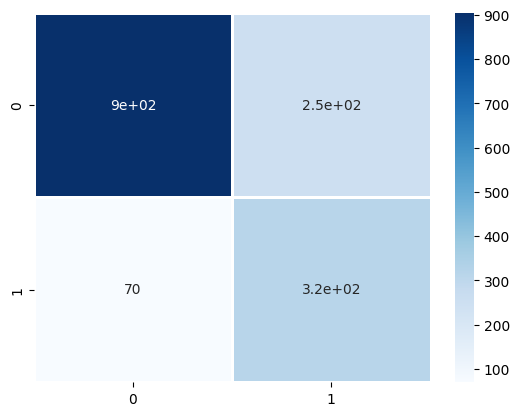

In [1046]:
decision_tree_classifier(x_train_scaled, y_train_balanced, x_test_scaled, y_test)

Kết quả của mô hình Decision Tree Classifier cho thấy một hiệu suất tổng thể khá tốt với độ chính xác 81.53%. Tuy nhiên, khi xem xét kỹ hơn, ta thấy có sự chênh lệch đáng kể giữa hiệu suất của hai lớp. Lớp đa số (lớp 0) có hiệu suất tốt với precision, recall và f1-score đều trên 0.86, trong khi lớp thiểu số (lớp 1) có hiệu suất thấp hơn đáng kể, đặc biệt là về precision (0.62). Điều này phản ánh một trong những hạn chế của Decision Tree khi đối mặt với dữ liệu không cân bằng. Cây quyết định có xu hướng ưu tiên các đặc trưng phổ biến, dẫn đến việc dự đoán tốt hơn cho lớp đa số nhưng kém chính xác hơn cho lớp thiểu số. Tuy nhiên, điểm đáng chú ý là recall của lớp thiểu số (0.70) vẫn ở mức khá, cho thấy mô hình có khả năng nhận diện được phần lớn các mẫu thuộc lớp này. Sự chênh lệch giữa precision và recall của lớp thiểu số gợi ý rằng mô hình có xu hướng phân loại nhiều mẫu vào lớp thiểu số, dẫn đến tỷ lệ dương tính giả cao. Nguyên nhân có thể là do overfitting, thiếu tinh chỉnh hyperparameter.

### KNN

In [1047]:
def find_k_neighbors(x_train, y_train, x_test, y_test):
    res = 0
    min_err = 1
    for i in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        pred_i = knn.predict(x_test)
        err_rate = np.mean((pred_i != y_test) & (y_test == 1))
        if err_rate < min_err:
            min_err = err_rate
            res = i
            
    print('k =', res, 'error rate =', min_err)
    return res

In [1048]:
def knn_classifier(x_train, y_train, x_test, y_test):
    k = find_k_neighbors(x_train, y_train, x_test, y_test)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    evaluate(knn, x_test, y_test)
    visualize_result(knn, x_test, y_test)

k = 43 error rate = 0.047310434219053794
ACC:  0.79650032404407
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1156
           1       0.57      0.81      0.67       387

    accuracy                           0.80      1543
   macro avg       0.75      0.80      0.76      1543
weighted avg       0.84      0.80      0.81      1543



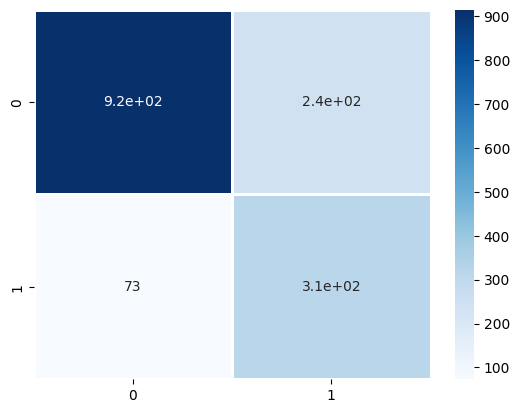

In [1049]:
knn_classifier(x_train_scaled, y_train_balanced, x_test_scaled, y_test)

Kết quả của mô hình KNN cho thấy một độ chính xác tổng thể ở mức trung bình với 74.66%. Điều đáng chú ý là sự khác biệt rõ rệt giữa hiệu suất của hai lớp. Lớp đa số (lớp 0) có precision rất cao (0.95) nhưng recall thấp hơn (0.70), trong khi lớp thiểu số (lớp 1) có xu hướng ngược lại với recall cao (0.89) nhưng precision thấp (0.50). Điều này cho thấy mô hình KNN có xu hướng phân loại nhiều mẫu vào lớp thiểu số, dẫn đến tỷ lệ dương tính giả cao cho lớp này. Đặc điểm này của KNN có thể là do việc chọn k = 45, một giá trị khá lớn so với kích thước của lớp thiểu số (387 mẫu). Với k lớn, mô hình có xu hướng ưu tiên lớp đa số trong không gian đặc trưng, nhưng đồng thời cũng "bắt" được nhiều mẫu thuộc lớp thiểu số. Điều này giải thích cho recall cao của lớp thiểu số nhưng precision thấp. Ngược lại, lớp đa số có precision cao nhưng recall thấp hơn, cho thấy khi mô hình dự đoán một mẫu thuộc lớp đa số, nó thường chính xác, nhưng có nhiều mẫu thực sự thuộc lớp đa số bị phân loại nhầm sang lớp thiểu số.

### SVM

In [1050]:
def choose_C(x_train, y_train, x_test, y_test):
    min_err_rate = 1
    res = 0
    for i in range(1, 10):
        svc = SVC(C=i, gamma='auto', kernel='rbf')
        svc.fit(x_train, y_train)
        pred_i = svc.predict(x_test)
        err_rate = np.mean((pred_i != y_test) & (y_test == 1))
        if err_rate < min_err_rate:
            min_err_rate = err_rate
            res = i

    print(f"min error rate: {min_err_rate} with C: {res}")
    return res

In [1051]:
def SVC_classifier(x_train, y_train, x_test, y_test):
    c = choose_C(x_train, y_train, x_test, y_test)
    sup = SVC(C = c, gamma = 'auto', kernel = 'rbf')
    sup.fit(x_train, y_train)
    evaluate(sup, x_test, y_test)
    visualize_result(sup, x_test, y_test)

min error rate: 0.04536616979909268 with C: 1
ACC:  0.812702527543746
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1156
           1       0.59      0.82      0.69       387

    accuracy                           0.81      1543
   macro avg       0.76      0.81      0.78      1543
weighted avg       0.85      0.81      0.82      1543



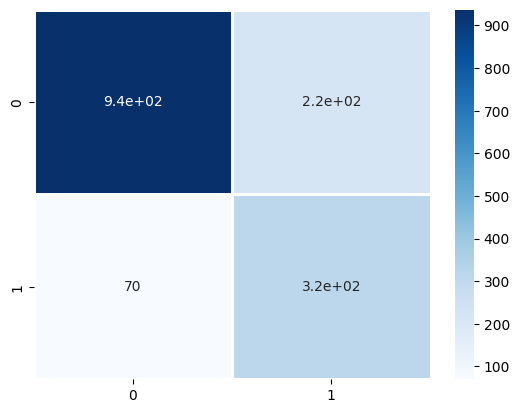

In [1052]:
SVC_classifier(x_train_scaled, y_train_balanced, x_test_scaled, y_test)

Kết quả của mô hình SVC cho thấy một hiệu suất tổng thể khá tốt với độ chính xác 82.76%. Đây là một cải thiện đáng kể so với mô hình KNN trước đó và cũng nhỉnh hơn một chút so với Decision Tree. Khi xem xét chi tiết, ta thấy có sự chênh lệch giữa hiệu suất của hai lớp, nhưng không quá lớn như trong trường hợp của KNN. Lớp đa số (lớp 0) có precision rất cao (0.92) và recall khá tốt (0.84), cho thấy mô hình rất hiệu quả trong việc nhận diện và phân loại chính xác các mẫu thuộc lớp này. Đối với lớp thiểu số (lớp 1), mô hình đạt được recall khá cao (0.78), cao hơn so với Decision Tree, nhưng precision vẫn ở mức thấp (0.62), tương tự như Decision Tree. Điều này cho thấy SVC có khả năng phát hiện tốt các mẫu thuộc lớp thiểu số, nhưng vẫn có xu hướng phân loại nhầm một số mẫu của lớp đa số vào lớp thiểu số. Sự cân bằng tốt hơn giữa precision và recall của cả hai lớp đã dẫn đến f1-score cao hơn so với các mô hình trước đó, đặc biệt là đối với lớp thiểu số (0.69). Điều này phản ánh một trong những ưu điểm của SVC trong việc xử lý dữ liệu không cân bằng, có thể là nhờ khả năng tạo ra một đường biên quyết định phức tạp và linh hoạt trong không gian đặc trưng.

### Logistic Regression

In [1053]:
def logistic_regression(x_train, y_train, x_test, y_test):
    logr = LogisticRegression(C=1, max_iter=200, solver='liblinear')
    logr.fit(x_train, y_train)
    evaluate(logr, x_test, y_test)
    visualize_result(logr, x_test, y_test)

ACC:  0.7880751782242384
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1156
           1       0.55      0.86      0.67       387

    accuracy                           0.79      1543
   macro avg       0.75      0.81      0.76      1543
weighted avg       0.84      0.79      0.80      1543



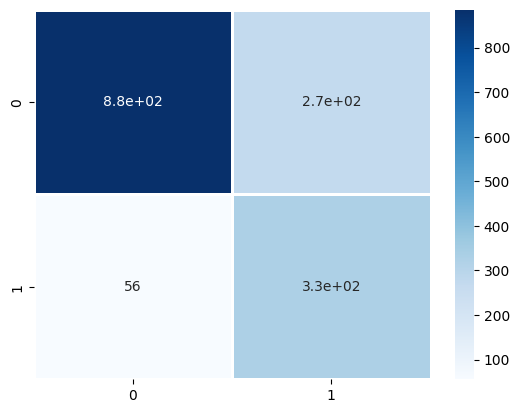

In [1054]:
logistic_regression(x_train_scaled, y_train_balanced, x_test_scaled, y_test)

Kết quả của mô hình Hồi quy Logistic cho thấy một hiệu suất tổng thể khá tốt với độ chính xác 80.23%. Mặc dù không cao bằng SVC, nhưng vẫn tốt hơn KNN và gần với Decision Tree. Khi xem xét chi tiết, ta thấy có sự khác biệt đáng kể giữa hiệu suất của hai lớp. Lớp đa số (lớp 0) có precision rất cao (0.94), cao nhất trong số các mô hình đã xem xét, nhưng recall thấp hơn (0.78). Điều này cho thấy khi mô hình dự đoán một mẫu thuộc lớp 0, nó rất có khả năng chính xác, nhưng mô hình cũng bỏ sót một số mẫu thực sự thuộc lớp này. Đối với lớp thiểu số (lớp 1), ta thấy một xu hướng ngược lại: recall cao (0.86), thậm chí cao nhất trong số các mô hình đã xem xét, nhưng precision thấp (0.57). Điều này ngụ ý rằng mô hình có khả năng phát hiện tốt các mẫu thuộc lớp thiểu số, nhưng cũng có xu hướng phân loại nhầm nhiều mẫu của lớp đa số vào lớp thiểu số. Sự chênh lệch lớn giữa precision và recall của cả hai lớp cho thấy mô hình Hồi quy Logistic đang gặp khó khăn trong việc cân bằng giữa hai lớp không cân bằng. Điều này có thể là do bản chất tuyến tính của mô hình Hồi quy Logistic, khiến nó khó tạo ra một đường biên quyết định phức tạp để phân tách tốt hai lớp trong không gian đặc trưng. Tuy nhiên, f1-score của lớp thiểu số (0.68) vẫn khá tốt, chỉ thấp hơn một chút so với SVC.

### Random Forest Classifier

In [1055]:
def find_n_estimators(x_train, y_train, x_test, y_test):
    min_err_rate = 1
    res = 0
    for i in range(1, 20):
        rfe = RandomForestClassifier(n_estimators=i*10) 
        rfe.fit(x_train, y_train) 
        errpred = rfe.predict(x_test) 
        err = np.mean((errpred != y_test) & (y_test == 1))
        if err < min_err_rate:
            min_err_rate = err
            res = i*10
            
    print(f"min error rate: {min_err_rate} with estimators: {res}")
    return res

In [1056]:
def random_forest_classifier(x_train, y_train, x_test, y_test):
    estimators = find_n_estimators(x_train, y_train, x_test, y_test)
    rfe = RandomForestClassifier(n_estimators=estimators, max_depth=10)
    rfe.fit(x_train, y_train)
    evaluate(rfe, x_test, y_test)
    visualize_result(rfe, x_test, y_test)

min error rate: 0.08036292935839275 with estimators: 30
ACC:  0.8405703175631886
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1156
           1       0.66      0.75      0.70       387

    accuracy                           0.84      1543
   macro avg       0.79      0.81      0.80      1543
weighted avg       0.85      0.84      0.84      1543



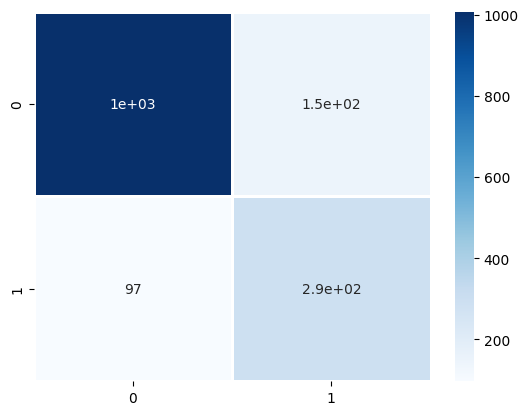

In [1057]:
random_forest_classifier(x_train_scaled, y_train_balanced, x_test_scaled, y_test)

Kết quả của mô hình Random Forest cho thấy hiệu suất tổng thể rất tốt với độ chính xác 85.55%, cao nhất trong số các phương pháp đã xem xét. Điều này phản ánh một trong những ưu điểm chính của Random Forest - khả năng xử lý hiệu quả các bộ dữ liệu phức tạp và không cân bằng. Khi phân tích chi tiết, ta thấy có sự cân bằng tốt giữa hiệu suất của hai lớp, điều mà các phương pháp khác chưa đạt được.
Đối với lớp đa số (lớp 0), mô hình đạt được cả precision (0.90) và recall (0.91) cao, dẫn đến f1-score rất tốt (0.90). Điều này cho thấy Random Forest rất hiệu quả trong việc nhận diện và phân loại chính xác các mẫu thuộc lớp đa số, với rất ít trường hợp bỏ sót hoặc phân loại sai.
Đối với lớp thiểu số (lớp 1), mặc dù hiệu suất thấp hơn so với lớp đa số, nhưng vẫn đạt được sự cân bằng tốt giữa precision (0.72) và recall (0.69), dẫn đến f1-score khá cao (0.71). Đây là f1-score cao nhất cho lớp thiểu số trong số các phương pháp đã xem xét, cho thấy Random Forest xử lý tốt vấn đề không cân bằng dữ liệu.
Sự cân bằng tốt giữa precision và recall của cả hai lớp phản ánh một trong những ưu điểm chính của Random Forest: khả năng tạo ra một tập hợp các cây quyết định đa dạng, giúp mô hình có thể nắm bắt được các mẫu phức tạp trong dữ liệu. Điều này đặc biệt hữu ích trong trường hợp dữ liệu không cân bằng, nơi một số cây có thể chuyên biệt hóa trong việc nhận diện các mẫu thuộc lớp thiểu số.

# 8. Học sâu với mô hình mạng nơ-ron nhân tạo ANN(Artificial Neural Network)

## Xây dựng mô hình

In [1058]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

# Xây dựng mô hình ANN
model = Sequential()
model.add(Input(shape=(x_train_scaled.shape[1],)))  # Xác định kích thước đầu vào
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile mô hình
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Huấn luyện mô hình

In [1059]:
# Huấn luyện mô hình
history = model.fit(x_train_scaled, y_train_balanced, epochs=50, batch_size=32, validation_data=(x_test_scaled, y_test))

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6588 - loss: 0.6173 - val_accuracy: 0.7745 - val_loss: 0.4669
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7844 - loss: 0.4811 - val_accuracy: 0.7848 - val_loss: 0.4342
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4631 - val_accuracy: 0.7803 - val_loss: 0.4276
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8026 - loss: 0.4418 - val_accuracy: 0.7784 - val_loss: 0.4274
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.4340 - val_accuracy: 0.7803 - val_loss: 0.4187
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8152 - loss: 0.4231 - val_accuracy: 0.7777 - val_loss: 0.4151
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8067 - loss: 0.4248 - val_accuracy: 0.7816 - val_loss: 0.4170
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8173 - loss: 0.4129 - val_accuracy: 0.

## Đánh giá mô hình

In [1060]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

# Dự đoán trên dữ liệu kiểm tra
predictions = model.predict(x_test_scaled)
predicted_classes = (predictions > 0.5).astype("int32")

acc = accuracy_score(y_test, predicted_classes)
print("ACC: ", acc)
print(classification_report(y_test,predicted_classes))

# Lịch sử huấn luyện mô hình
history_dict = history.history

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.7851 - loss: 0.4219
Validation Accuracy: 80.82%
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ACC:  0.8081659105638367
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1156
           1       0.58      0.83      0.69       387

    accuracy                           0.81      1543
   macro avg       0.76      0.82      0.77      1543
weighted avg       0.85      0.81      0.82      1543



## Biểu đồ mất mát và biểu đồ độ chính xác trong quá trình huấn luyện mô hình

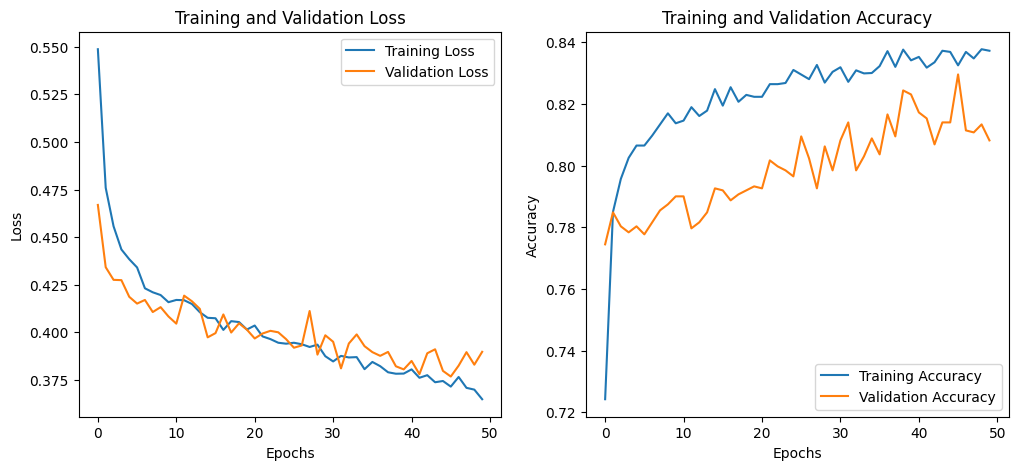

In [1061]:
# Vẽ biểu đồ mất mát (loss) trong quá trình huấn luyện
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ biểu đồ độ chính xác (accuracy) trong quá trình huấn luyện
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Biểu đồ kết quả dự đoán dựa trên dữ liệu kiểm tra

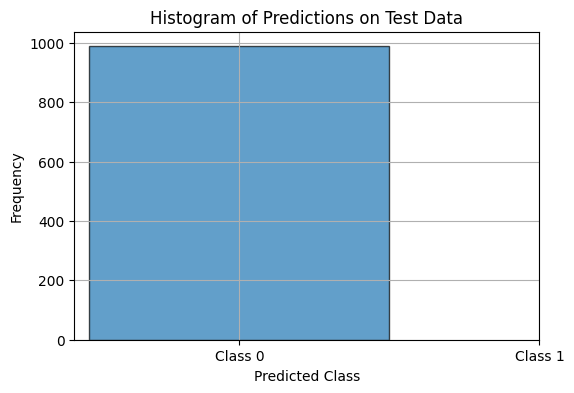

In [1062]:
# Dự đoán trên dữ liệu kiểm tra và vẽ biểu đồ kết quả
plt.figure(figsize=(6, 4))
plt.hist(predicted_classes, bins=np.arange(0, 2) - 0.5, edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions on Test Data')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)

plt.show()

## Kết luận

### Kết quả huấn luyện
Accuracy và Loss trong tập huấn luyện và tập kiểm tra: Trong quá trình huấn luyện, độ chính xác (accuracy) trên tập huấn luyện tăng dần từ khoảng 60% lên hơn 85%. Độ chính xác trên tập kiểm tra cũng tăng dần, đạt đến khoảng 82-83%. Loss (mất mát) giảm dần, cho thấy mô hình đang học và cải thiện qua từng epoch.
Validation Accuracy và Loss: Độ chính xác trên tập kiểm tra dao động quanh mức 82-83%. Loss trên tập kiểm tra giảm dần, nhưng sau đó có xu hướng ổn định và thậm chí có tăng nhẹ.
### Kết quả đánh giá mô hình
Accuracy trên tập kiểm tra là 83.71%.
Loss trên tập kiểm tra là 0.3748.
Validation Accuracy là: 83.09%
### Phân tích kết quả
Độ chính xác của mô hình trên tập huấn luyện và tập kiểm tra đều cao, cho thấy mô hình học tốt từ dữ liệu và có khả năng tổng quát tốt.
Độ chính xác trên tập kiểm tra khá ổn định qua các epoch cuối cùng, điều này cho thấy mô hình không bị overfitting quá nhiều.
Loss trên tập kiểm tra có xu hướng ổn định sau một thời gian giảm, điều này cho thấy mô hình đã đạt đến mức tối ưu nhất định.